# Building Keras model, Part 02
Train a deep MLP on the MNIST dataset (you can load it using keras.data sets.mnist.load_data() . See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models 
from tensorflow.keras import layers
import os

%matplotlib inline

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full.shape

11501568/11490434 [==============================] - 3s 0us/step


(60000, 28, 28)

In [7]:
# separate valid set, train set, and scale down pixel to range 0-1
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

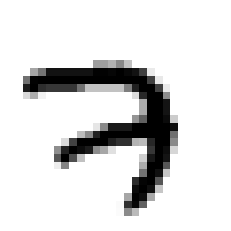

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

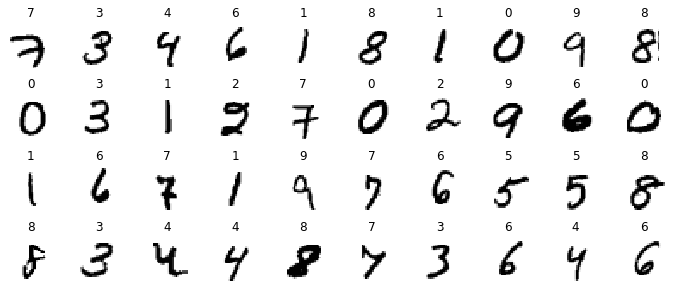

In [9]:
# y labels are the class id in int8
# look at a sample of the image in the dataset
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
# Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. 
# It will also record the learning rate and the loss at each iteration:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [11]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# build model
model = models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(300, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(10, activation="softmax")
])

# learning rate starts with 1e-3
sgd = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

# grow up learning rate by 0.5%
expon_lr = ExponentialLearningRate(factor=1.005)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


2022-04-09 17:29:40.813076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 17:29:40.872687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 17:29:40.872831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 17:29:40.873718: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
# let's test with 1 epoch
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[expon_lr], verbose=0)

2022-04-09 17:33:39.066899: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Text(0, 0.5, 'Loss')

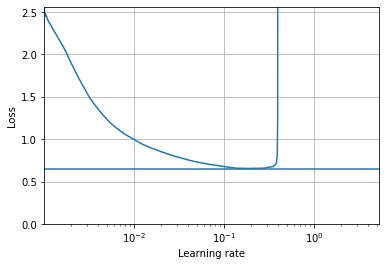

In [13]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [14]:
# The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

sgd = keras.optimizers.SGD(learning_rate=3e-1, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [15]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [16]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb], verbose=0)

In [17]:
# test current training model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 749us/step - loss: 2.3171 - accuracy: 0.1009


[2.3171050548553467, 0.10090000182390213]

In [18]:
# load the best model
model = models.load_model('my_mnist_model.h5')
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 744us/step - loss: 2.3084 - accuracy: 0.0974


[2.3084399700164795, 0.09740000218153]

In [21]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --port=6006